# Trénovanie modelu na základe DST indexu 6h dopredu 6h dozadu

In [1]:
import pandas as pd
import numpy as np
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import seaborn as sns

from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential

from keras.layers import Dense, Activation, Dropout, Input, Conv1D, LSTM, MaxPooling1D, Flatten, TimeDistributed, Bidirectional
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import Model


from scipy.special import expit, logit

from sklearn.metrics import confusion_matrix, classification_report, matthews_corrcoef

2024-05-14 18:06:06.759158: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Načitanie dát, odstránenie na hodnôt, určenie predikovaného atribútu

In [2]:
train = pd.read_csv('train_omni.csv')
test = pd.read_csv('test_omni.csv')
features = ['time1',
           'DST',
            'DST+6']
test = test[features]
train = train[features]
train = train.dropna()
train['time1']=pd.to_datetime(train['time1'])
test['time1']=pd.to_datetime(test['time1'])
predicted_label = 'DST+6'

y_col='DST+6'
valid_size = int(len(train) * 0.2)
valid = train.iloc[-valid_size:,:].copy()
train = train.iloc[:-valid_size,:].copy()

y_train = train[y_col].values.copy()
X_train = train['DST'].values.copy()
y_val = valid[y_col].values.copy()
X_val = valid['DST'].values.copy()
y_test = test[y_col].values.copy()
X_test = test['DST'].values.copy()

In [3]:
n_input = 6  # how many samples/rows/timesteps to look in the past in order to forecast the next sample
n_features= len(X_train)  # how many predictors/Xs/features we have to predict y
b_size = 256  # Number of timeseries samples in each batch

train_generator = TimeseriesGenerator(X_train, y_train, length=n_input, batch_size=b_size)
val_generator = TimeseriesGenerator(X_val, y_val, length=n_input, batch_size=b_size)
test_generator = TimeseriesGenerator(X_test, y_test, length=n_input, batch_size=256)

In [4]:
print("Počet batchov: ", len(train_generator))
print("Každý batch má features (X zložku) a labels (y zložku): ", len(train_generator[0]))
print("Dĺžka X zložky batchu: ", len(train_generator[0][0]))
print("Dĺžka y zložky batchu (počet meraní v batchi): ",len(train_generator[0][1]))
print("Počet riadkov braných do úvahy pre jedno meranie (koľko sa pozerá dozadu): ", len(train_generator[0][0][0]))

Počet batchov:  1139
Každý batch má features (X zložku) a labels (y zložku):  2
Dĺžka X zložky batchu:  256
Dĺžka y zložky batchu (počet meraní v batchi):  256
Počet riadkov braných do úvahy pre jedno meranie (koľko sa pozerá dozadu):  6


In [5]:
inputs = Input(shape=(6,1))
c = Bidirectional(LSTM(128, return_sequences=True, dropout=0.1,recurrent_dropout=0.1))(inputs)
c = LSTM(128, return_sequences=True)(c)
c = TimeDistributed(Dense(1, activation='linear'))(c)
output = Flatten()(c)
output = Dense(1, activation='linear')(output)
model = Model(inputs=inputs, outputs=output)
model.compile(loss='mse', optimizer='adam', metrics=["mae"])
print(model.summary())

2024-05-07 14:51:26.385158: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 6, 1)]            0         
                                                                 
 bidirectional (Bidirectiona  (None, 6, 256)           133120    
 l)                                                              
                                                                 
 lstm_1 (LSTM)               (None, 6, 128)            197120    
                                                                 
 time_distributed (TimeDistr  (None, 6, 1)             129       
 ibuted)                                                         
                                                                 
 flatten (Flatten)           (None, 6)                 0         
                                                                 
 dense_1 (Dense)             (None, 1)                 7     

In [6]:
# callbacks
saved_model = "model_6_6.hdf5"
checkpoint = ModelCheckpoint(saved_model, monitor='val_mae', verbose=1, save_best_only=True, mode='min')
early = EarlyStopping(monitor="val_mae", mode="min", patience=25)
callbacks_list = [checkpoint, early]

In [7]:
# fit
history = model.fit(train_generator, validation_data=val_generator, epochs=20, verbose=1, callbacks = callbacks_list)

Epoch 1/20
1138/1139 [============================>.] - ETA: 0s - loss: 227.8703 - mae: 9.0062
Epoch 1: val_mae improved from inf to 8.61987, saving model to model_6_6.hdf5
1139/1139 [==============================] - 52s 42ms/step - loss: 227.7197 - mae: 9.0029 - val_loss: 233.1748 - val_mae: 8.6199
Epoch 2/20
1139/1139 [==============================] - ETA: 0s - loss: 182.4801 - mae: 8.3656
Epoch 2: val_mae improved from 8.61987 to 8.57791, saving model to model_6_6.hdf5
1139/1139 [==============================] - 45s 39ms/step - loss: 182.4801 - mae: 8.3656 - val_loss: 220.2289 - val_mae: 8.5779
Epoch 3/20
1139/1139 [==============================] - ETA: 0s - loss: 175.7465 - mae: 8.2901
Epoch 3: val_mae improved from 8.57791 to 8.34457, saving model to model_6_6.hdf5
1139/1139 [==============================] - 45s 39ms/step - loss: 175.7465 - mae: 8.2901 - val_loss: 212.2971 - val_mae: 8.3446
Epoch 4/20
1139/1139 [==============================] - ETA: 0s - loss: 171.9250 - mae

In [5]:
model = keras.models.load_model('model_6_6.hdf5')

2024-05-14 18:06:22.838750: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [6]:
# prediction
y_pred = model.predict(test_generator)

610/610 [==============================] - 7s 10ms/step


Confusion matrix: 
[[120521   4892]
 [ 11058  19639]]


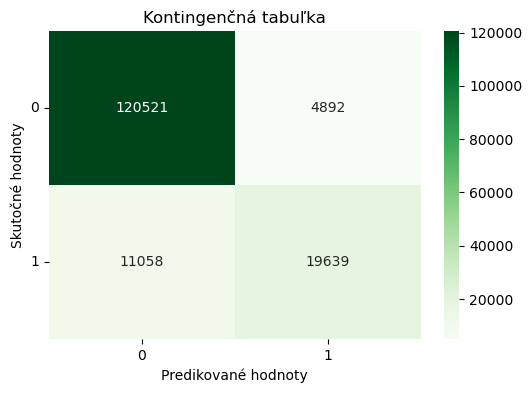

In [7]:
y_pred2 = np.where(y_pred <= -20, 1, 0)
y_test2 = np.where(y_test[n_input:] <= -20, 1, 0)

cm = confusion_matrix(y_test2, y_pred2)
print("Confusion matrix: \n" + str(cm))

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap='Greens')
plt.title('Kontingenčná tabuľka')
plt.xlabel('Predikované hodnoty')
plt.ylabel('Skutočné hodnoty')
plt.xticks(ticks=[0.5, 1.5], labels=['0', '1'])
plt.yticks(ticks=[0.5, 1.5], labels=['0', '1'], rotation=0)
plt.show()

In [8]:
print(classification_report(y_test2, y_pred2))

              precision    recall  f1-score   support

           0       0.92      0.96      0.94    125413
           1       0.80      0.64      0.71     30697

    accuracy                           0.90    156110
   macro avg       0.86      0.80      0.82    156110
weighted avg       0.89      0.90      0.89    156110



In [9]:
df = pd.DataFrame(data={"time": test['time1'][n_input:],"y_true": y_test[n_input:].reshape(-1) , "y_predict": y_pred.reshape(-1)})

In [10]:
df.describe()

,y_true,y_predict
count,156105.000000,156110.000000
mean,-9.785708,-9.395611
std,16.323633,13.514838
min,-374.000000,-183.644135
25%,-16.000000,-15.281713
50%,-7.000000,-7.233490
75%,0.000000,-0.533595
max,77.000000,15.094059


<AxesSubplot:>

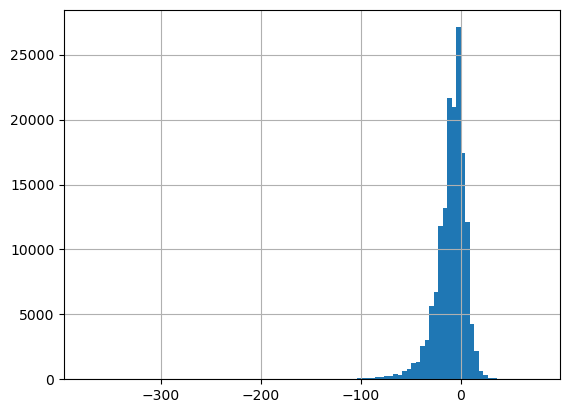

In [11]:
df["y_true"].hist(bins=100)

<AxesSubplot:>

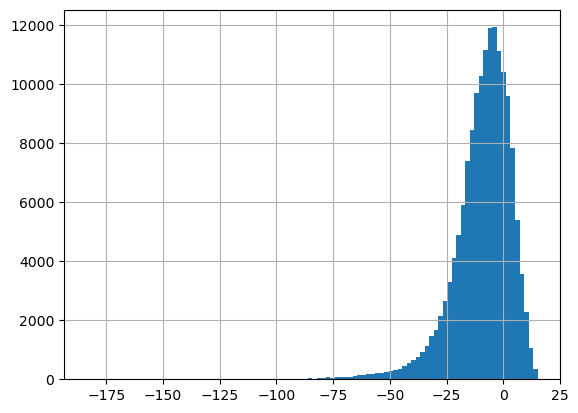

In [12]:
df["y_predict"].hist(bins=100)

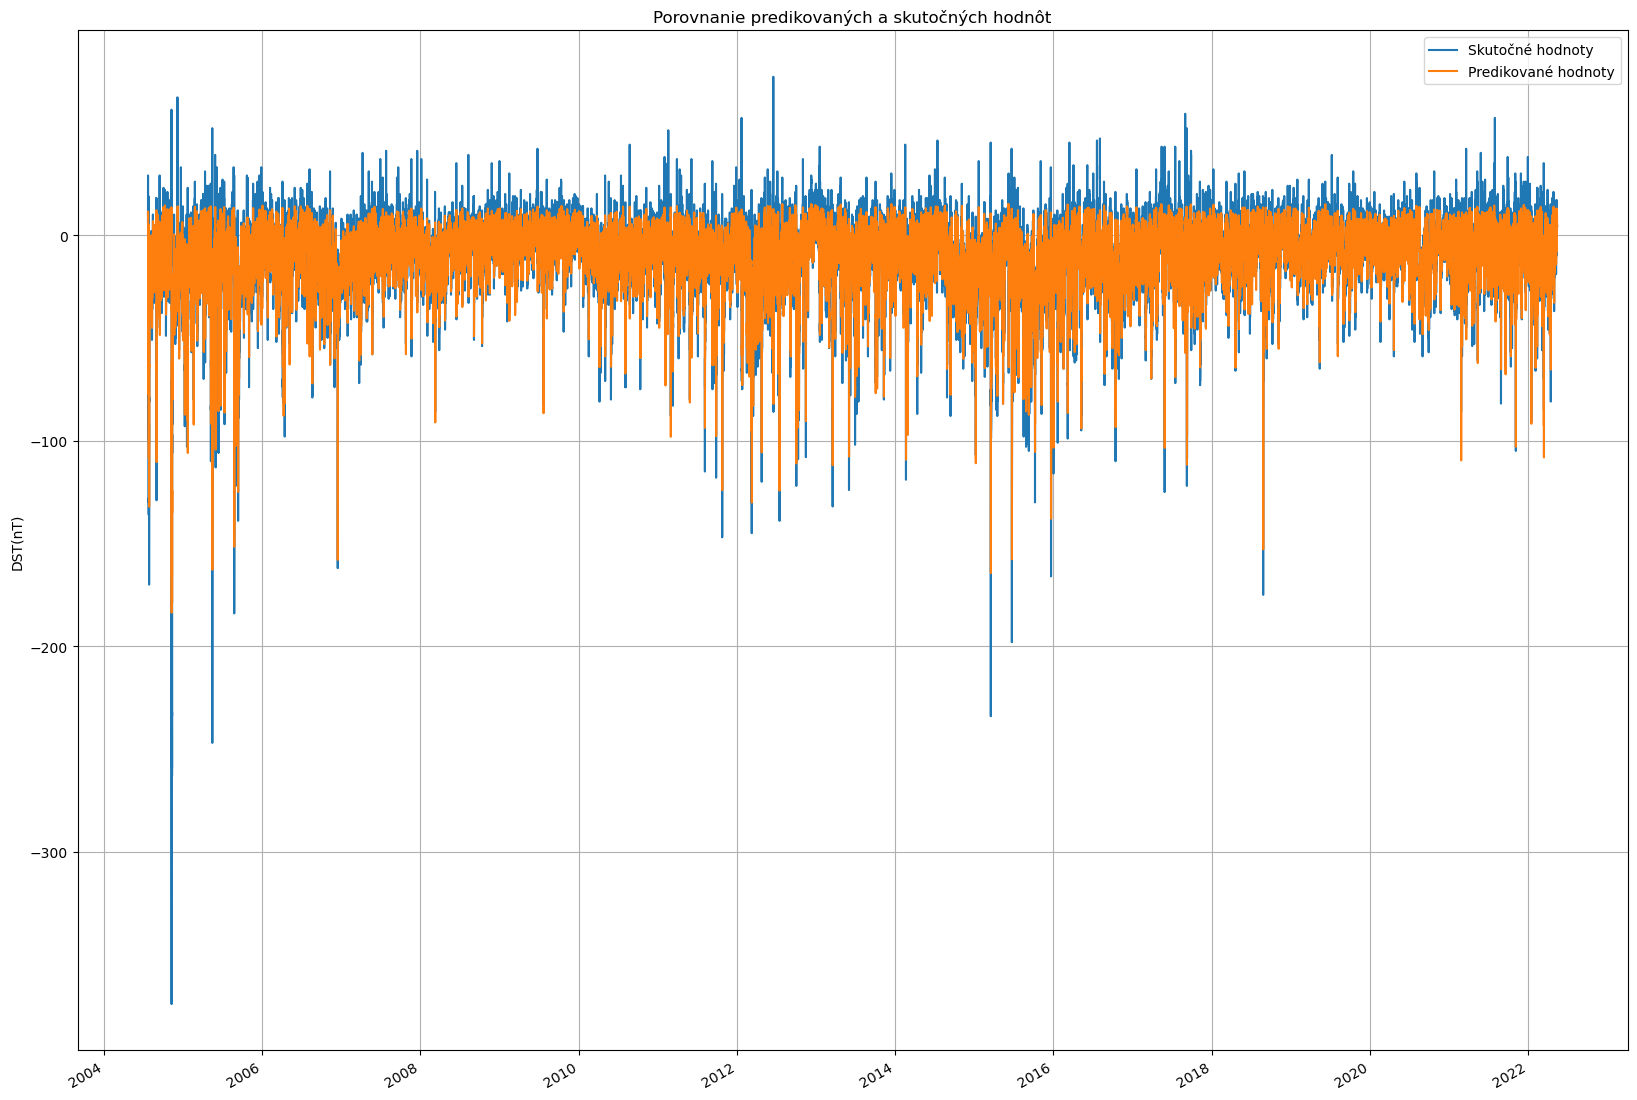

In [13]:
plt.figure(figsize=(20, 15))
plt.plot(df['time'],df['y_true'], label='Skutočné hodnoty')
plt.plot(df['time'],df['y_predict'], label='Predikované hodnoty')
plt.legend()
plt.ylabel('DST(nT)')
plt.title('Porovnanie predikovaných a skutočných hodnôt')
plt.gcf().autofmt_xdate()
plt.grid(True)

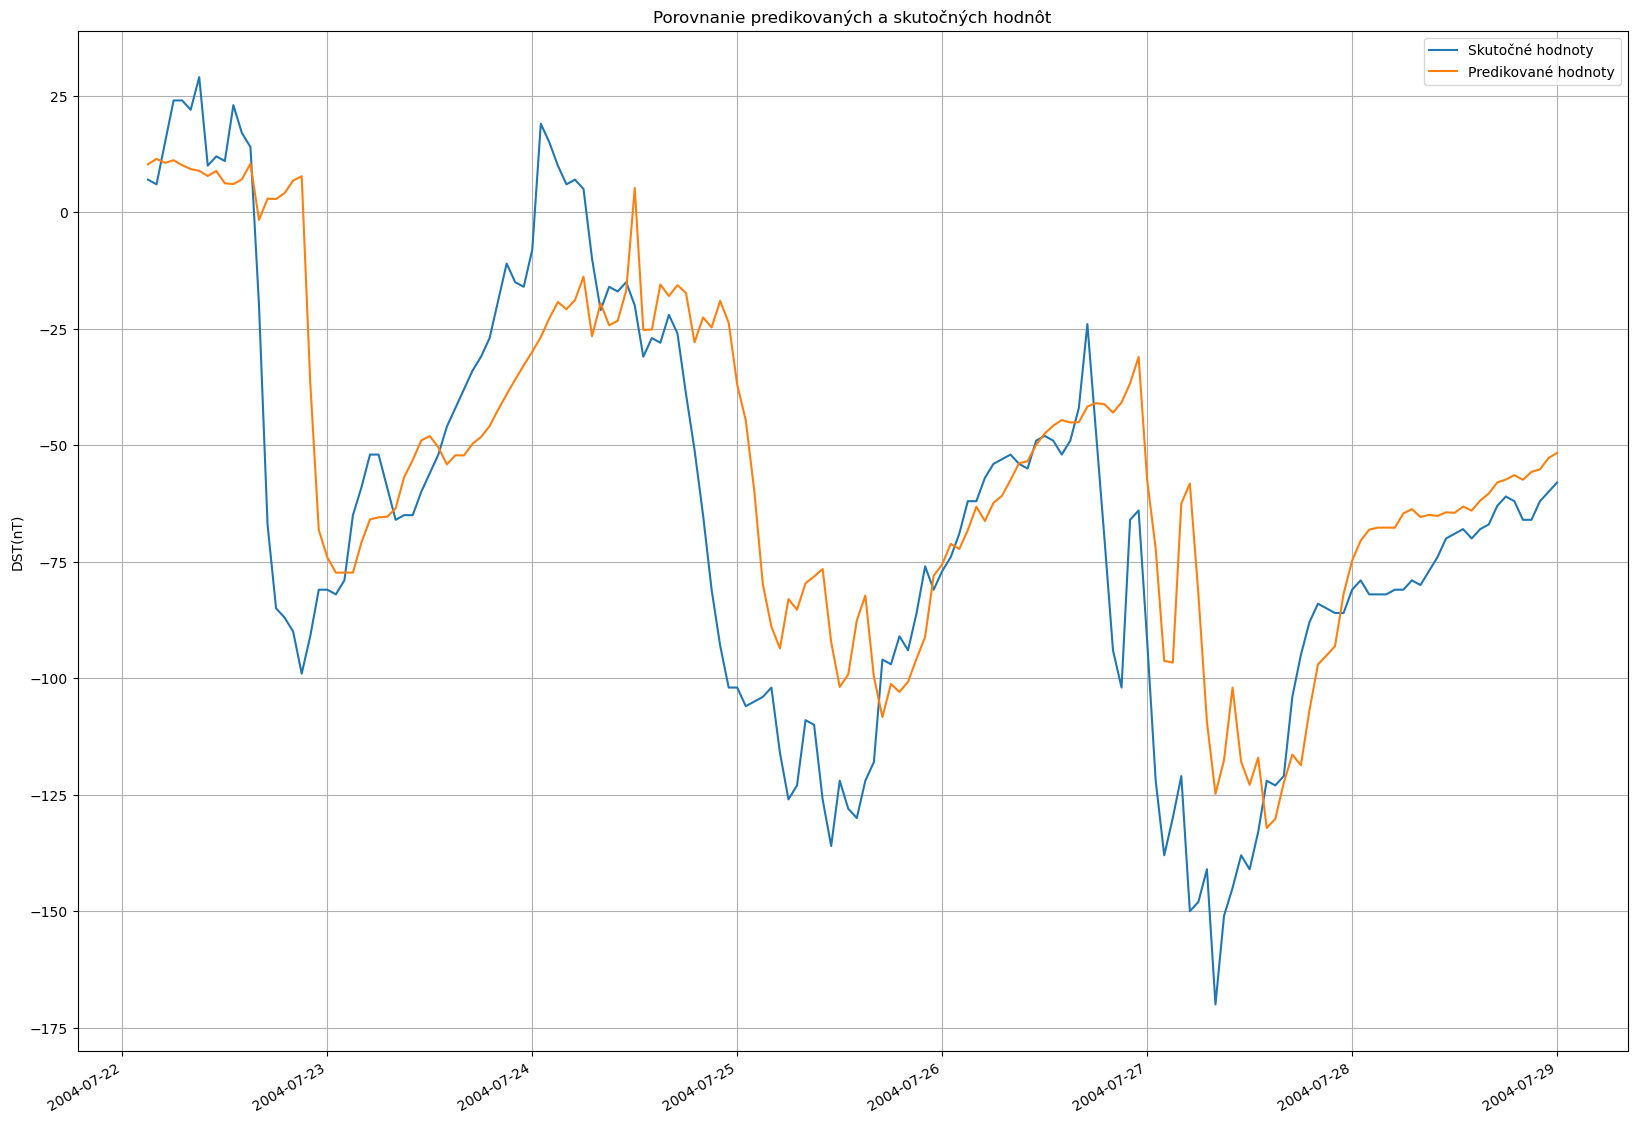

In [14]:
plt.figure(figsize=(20, 15))
data_subset = df.head(166)
plt.plot(data_subset['time'], data_subset['y_true'], label='Skutočné hodnoty')
plt.plot(data_subset['time'], data_subset['y_predict'], label='Predikované hodnoty')
plt.legend()
plt.ylabel('DST(nT)')
plt.title('Porovnanie predikovaných a skutočných hodnôt')
plt.gcf().autofmt_xdate()
plt.grid(True)

In [17]:
df.to_csv('predikcie_6_6.csv')

# Vysvetliteľnosť modelu na základe DST indexu 6h dopredu 6 dozadu

In [15]:
from sklearn.preprocessing import minmax_scale
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D

In [16]:
#hodnota pre vypínanie intervalov priemer
value_for_shutdown = np.mean(X_test)
value_for_shutdown

-9.784205334494862

In [17]:
#hodnota pre vypínanie intervalov median
value_for_shutdown_median = np.median(X_test)
value_for_shutdown_median

-7.0

In [18]:
#povodna funkcia
def perturbation_method(data_instance, model, interval_length, value_for_shutdown):
    testovacia_vzorka = data_instance.reshape(1,n_input,1)
    y_pred_single = model.predict(testovacia_vzorka)
    
    number_of_intervals = n_input // interval_length
    importance_of_intervals = []
    for i in range(number_of_intervals):
        perturbovana_vzorka = np.zeros_like(testovacia_vzorka)
        perturbovana_vzorka[:] = testovacia_vzorka[:]
        
        perturbovana_vzorka[0][i*interval_length:(i+1)*interval_length][0] = value_for_shutdown
        nova_predikcia = model.predict(perturbovana_vzorka)
        importance = y_pred_single[0][0] - nova_predikcia[0][0]
        importance_of_intervals.append(importance)
 
    audio_scaled = minmax_scale(importance_of_intervals, feature_range=(0,1))
    for i in range(number_of_intervals):
        audio_scaled[i] = 1- audio_scaled[i]
    audio_scaled1 = np.repeat(audio_scaled,interval_length)
    
    # Vizualizácia
    dst = data_instance

    time_data = np.arange(-6,0)
    fig = plt.figure(figsize=(26,5))
    
    plt.plot(time_data, dst[0:n_input],color='black')
    plt.title("Vysvetliteľnosť indexu DST"+" (dlžka perturbovaného intervalu je "+str(interval_length)+")", fontsize=24)
    plt.xlabel("Časový priebeh (h)", fontsize=20)
    plt.ylabel("DST (nT)", fontsize=20)
    
    ax = plt.subplot(111)
    plt.minorticks_on()
    grid_x_ticks = np.arange(0, n_input+1, 1)
    ax.set_xticks(grid_x_ticks , minor=True)
    plt.tick_params(axis='x', labelsize=20)
    plt.tick_params(axis='y', labelsize=20)
    plt.grid(which='minor', linestyle=':', color='black', linewidth='0.5')
    plt.grid(which='major', linestyle=':', color='black', linewidth='0.5')
    
    custom_lines = [Line2D([0], [0], color= 'red', lw=4),
                    Line2D([0], [0], color='orange', lw=4),
                    Line2D([0], [0], color='yellow', lw=4)]
    
    ax.legend(custom_lines,['Veľmi dôležitá oblasť', 'Dôležitá oblasť', 'Menej dôležitá oblasť','Oblasť predikcie'],loc='center left', bbox_to_anchor=(1, 0.5), fontsize=20)
    
    ymin, ymax = plt.ylim()
    for i in range(len(audio_scaled1)):
        if audio_scaled1[i] > 0.85:
            plt.fill_betweenx([ymin, ymax], time_data[i], time_data[i]+1, color='red', alpha=0.8)
        elif 0.6 < audio_scaled1[i] <= 0.85:
            plt.fill_betweenx([ymin, ymax], time_data[i], time_data[i]+1, color='orange', alpha=1)
        elif 0.5 < audio_scaled1[i] <= 0.6:
            plt.fill_betweenx([ymin, ymax], time_data[i], time_data[i]+1, color='yellow', alpha=0.3)
    #plt.fill_between(time_data, ymin, ymax, where= (audio_scaled1[0:n_input] > 0.85) & (audio_scaled1[0:n_input] <= 1) , color='red', alpha=0.8)
    #plt.fill_between(time_data, ymin, ymax, where= (audio_scaled1[0:n_input] > 0.6) & (audio_scaled1[0:n_input] <= 0.85), color='orange', alpha=1)
    #plt.fill_between(time_data, ymin, ymax, where= (audio_scaled1[0:n_input] > 0.5) & (audio_scaled1[0:n_input] <= 0.6), color='yellow', alpha=0.3)
    
    plt.close(fig)
    return fig

In [19]:
#upravena funkcia podla vysledkov z dotaznika
def perturbation_method(data_instance, model, interval_length, value_for_shutdown):
    testovacia_vzorka = data_instance.reshape(1,n_input,1)
    y_pred_single = model.predict(testovacia_vzorka)
    
    number_of_intervals = n_input // interval_length
    importance_of_intervals = []
    for i in range(number_of_intervals):
        perturbovana_vzorka = np.zeros_like(testovacia_vzorka)
        perturbovana_vzorka[:] = testovacia_vzorka[:]
        
        perturbovana_vzorka[0][i*interval_length:(i+1)*interval_length][0] = value_for_shutdown
        nova_predikcia = model.predict(perturbovana_vzorka)
        importance = y_pred_single[0][0] - nova_predikcia[0][0]
        importance_of_intervals.append(importance)
 
    audio_scaled = minmax_scale(importance_of_intervals, feature_range=(0,1))
    for i in range(number_of_intervals):
        audio_scaled[i] = 1- audio_scaled[i]
    audio_scaled1 = np.repeat(audio_scaled,interval_length)
    
    # Vizualizácia
    dst = data_instance

    time_data = np.arange(-6,0)
    fig = plt.figure(figsize=(26,5))
    
    plt.plot(time_data, dst[0:n_input],color='black')
    plt.title("Vysvetliteľnosť indexu DST"+" (dlžka perturbovaného intervalu je "+str(interval_length)+")", fontsize=24)
    plt.xlabel("Časový priebeh (h)", fontsize=20)
    plt.ylabel("DST (nT)", fontsize=20)
    
    ax = plt.subplot(111)
    plt.minorticks_on()
    grid_x_ticks = np.arange(0, n_input+1, 1)
    ax.set_xticks(grid_x_ticks , minor=True)
    plt.tick_params(axis='x', labelsize=20)
    plt.tick_params(axis='y', labelsize=20)
    plt.grid(which='minor', linestyle=':', color='black', linewidth='0.5')
    plt.grid(which='major', linestyle=':', color='black', linewidth='0.5')
    
    custom_lines = [Line2D([0], [0], color= 'red', lw=4),
                    Line2D([0], [0], color='orange', lw=4),
                    Line2D([0], [0], color='yellow', lw=4)]
    
    ax.legend(custom_lines,['Veľmi dôležitá oblasť', 'Dôležitá oblasť', 'Menej dôležitá oblasť','Oblasť predikcie'],loc='center left', bbox_to_anchor=(1, 0.5), fontsize=20)
    
    ymin, ymax = plt.ylim()
    for i in range(len(audio_scaled1)):
        if audio_scaled1[i] > 0.85:
            plt.fill_betweenx([ymin, ymax], time_data[i],time_data[i],  color='red', alpha=1, linewidth=10.0)
        elif 0.6 < audio_scaled1[i] <= 0.85:
            plt.fill_betweenx([ymin, ymax], time_data[i], time_data[i], color='orange', alpha=1, linewidth=10.0)
        elif 0.5 < audio_scaled1[i] <= 0.6:
            plt.fill_betweenx([ymin, ymax], time_data[i], time_data[i], color='yellow', alpha=1, linewidth=10.0)
    #plt.fill_between(time_data, ymin, ymax, where= (audio_scaled1[0:n_input] > 0.85) & (audio_scaled1[0:n_input] <= 1) , color='red', alpha=0.8)
    #plt.fill_between(time_data, ymin, ymax, where= (audio_scaled1[0:n_input] > 0.6) & (audio_scaled1[0:n_input] <= 0.85), color='orange', alpha=1)
    #plt.fill_between(time_data, ymin, ymax, where= (audio_scaled1[0:n_input] > 0.5) & (audio_scaled1[0:n_input] <= 0.6), color='yellow', alpha=0.3)
    
    plt.close(fig)
    return fig


In [20]:
# povodna funkcia 
def perturbation_method_with_predicted_value(data_instance, model, interval_length, value_for_shutdown):
    testovacia_vzorka = data_instance.reshape(1,n_input,1)
    y_pred_single = model.predict(testovacia_vzorka)
    
    number_of_intervals = n_input // interval_length
    importance_of_intervals = []
    for i in range(number_of_intervals):
        perturbovana_vzorka = np.zeros_like(testovacia_vzorka)
        perturbovana_vzorka[:] = testovacia_vzorka[:]
        
        perturbovana_vzorka[0][i*interval_length:(i+1)*interval_length][0] = value_for_shutdown
        nova_predikcia = model.predict(perturbovana_vzorka)
        importance = y_pred_single[0][0] - nova_predikcia[0][0]
        importance_of_intervals.append(importance)
 
    audio_scaled = minmax_scale(importance_of_intervals, feature_range=(0, 1))
    for i in range(number_of_intervals):
        audio_scaled[i] = 1 - audio_scaled[i]
    # audio_scaled1 = np.repeat(audio_scaled,interval_length)
    audio_scaled1 = np.concatenate([np.repeat(audio_scaled, interval_length), np.zeros(1),np.zeros(1)])

    # Vizualizácia
    dst = data_instance
    dst_new = np.append(dst,y_pred_single)
    dst_new = np.append(dst_new,y_pred_single)
    
    
    time_data = np.arange(-6,2)
    fig = plt.figure(figsize=(26,5))
    
    plt.plot(time_data, dst_new[0:n_input+2],color='black')
    plt.title("Vysvetliteľnosť indexu DST"+" (dlžka perturbovaného intervalu je "+str(interval_length)+")", fontsize=24)
    plt.xlabel("Časový priebeh (h)", fontsize=20)
    plt.ylabel("DST (nT)", fontsize=20)
    
    
    ax = plt.subplot(111)
    plt.minorticks_on()
    grid_x_ticks = np.arange(0, n_input+2, 1)
    ax.set_xticks(grid_x_ticks , minor=True)
    plt.tick_params(axis='x', labelsize=20)
    plt.tick_params(axis='y', labelsize=20)
    plt.grid(which='minor', linestyle=':', color='black', linewidth='0.5')
    plt.grid(which='major', linestyle=':', color='black', linewidth='0.5')
    
    custom_lines = [Line2D([0], [0], color= 'red', lw=4),
                    Line2D([0], [0], color='orange', lw=4),
                    Line2D([0], [0], color='yellow', lw=4),
                    Line2D([0], [0], color='green', lw=4)]
    
    ax.legend(custom_lines,['Veľmi dôležitá oblasť', 'Dôležitá oblasť', 'Menej dôležitá oblasť','Oblasť predikcie'],loc='center left', bbox_to_anchor=(1, 0.5), fontsize = 20)
    
    ymin, ymax = plt.ylim()
    for i in range(len(audio_scaled1)):
        if audio_scaled1[i] > 0.85:
            plt.fill_betweenx([ymin, ymax], time_data[i], time_data[i]+1, color='red', alpha=0.8)
        elif 0.6 < audio_scaled1[i] <= 0.85:
            plt.fill_betweenx([ymin, ymax], time_data[i], time_data[i]+1, color='orange', alpha=1)
        elif 0.5 < audio_scaled1[i] <= 0.6:
            plt.fill_betweenx([ymin, ymax], time_data[i], time_data[i]+1, color='yellow', alpha=0.3)


    #plt.fill_between(time_data, ymin, ymax, where= (audio_scaled1[0:n_input+1] > 0.85) & (audio_scaled1[0:n_input+1] <= 1) , color='red', alpha=0.8)
    #plt.fill_between(time_data, ymin, ymax, where= (audio_scaled1[0:n_input+1] > 0.6) & (audio_scaled1[0:n_input+1] <= 0.85), color='orange', alpha=1)
    plt.fill_betweenx([ymin, ymax], time_data[6], time_data[6]+1, color='green', alpha=0.3)
    
    
    plt.close(fig)
    return fig

In [21]:
#upravena funkcia podla vysledkov z dotaznika
def perturbation_method_with_predicted_value(data_instance, model, interval_length, value_for_shutdown):
    testovacia_vzorka = data_instance.reshape(1,n_input,1)
    y_pred_single = model.predict(testovacia_vzorka)
    
    number_of_intervals = n_input // interval_length
    importance_of_intervals = []
    for i in range(number_of_intervals):
        perturbovana_vzorka = np.zeros_like(testovacia_vzorka)
        perturbovana_vzorka[:] = testovacia_vzorka[:]
        
        perturbovana_vzorka[0][i*interval_length:(i+1)*interval_length][0] = value_for_shutdown
        nova_predikcia = model.predict(perturbovana_vzorka)
        importance = y_pred_single[0][0] - nova_predikcia[0][0]
        importance_of_intervals.append(importance)
 
    audio_scaled = minmax_scale(importance_of_intervals, feature_range=(0, 1))
    for i in range(number_of_intervals):
        audio_scaled[i] = 1 - audio_scaled[i]
    # audio_scaled1 = np.repeat(audio_scaled,interval_length)
    audio_scaled1 = np.concatenate([np.repeat(audio_scaled, interval_length), np.zeros(1)])

    # Vizualizácia
    dst = data_instance
    dst_new = np.append(dst,y_pred_single)
    dst_new = np.append(dst_new,y_pred_single)
    
    
    time_data = np.arange(-6,1)
    fig = plt.figure(figsize=(26,5))
    
    plt.plot(time_data, dst_new[0:n_input+1],color='black')
    plt.title("Vysvetliteľnosť indexu DST"+" (dlžka perturbovaného intervalu je "+str(interval_length)+")", fontsize=24)
    plt.xlabel("Časový priebeh (h)", fontsize=20)
    plt.ylabel("DST (nT)", fontsize=20)
    
    
    ax = plt.subplot(111)
    plt.minorticks_on()
    grid_x_ticks = np.arange(0, n_input+1, 1)
    ax.set_xticks(grid_x_ticks , minor=True)
    plt.tick_params(axis='x', labelsize=20)
    plt.tick_params(axis='y', labelsize=20)
    plt.grid(which='minor', linestyle=':', color='black', linewidth='0.5')
    plt.grid(which='major', linestyle=':', color='black', linewidth='0.5')
    
    custom_lines = [Line2D([0], [0], color= 'red', lw=4),
                    Line2D([0], [0], color='orange', lw=4),
                    Line2D([0], [0], color='yellow', lw=4),
                    Line2D([0], [0], color='green', lw=4)]
    
    ax.legend(custom_lines,['Veľmi dôležitá oblasť', 'Dôležitá oblasť', 'Menej dôležitá oblasť','Oblasť predikcie'],loc='center left', bbox_to_anchor=(1, 0.5), fontsize = 20)
    
    ymin, ymax = plt.ylim()
    for i in range(len(audio_scaled1)):
        if audio_scaled1[i] > 0.85:
            plt.fill_betweenx([ymin, ymax], time_data[i],time_data[i],  color='red', alpha=1, linewidth=10.0)
        elif 0.6 < audio_scaled1[i] <= 0.85:
            plt.fill_betweenx([ymin, ymax], time_data[i], time_data[i], color='orange', alpha=1, linewidth=10.0)
        elif 0.5 < audio_scaled1[i] <= 0.6:
            plt.fill_betweenx([ymin, ymax], time_data[i], time_data[i], color='yellow', alpha=1, linewidth=10.0)
   


    #plt.fill_between(time_data, ymin, ymax, where= (audio_scaled1[0:n_input+1] > 0.85) & (audio_scaled1[0:n_input+1] <= 1) , color='red', alpha=0.8)
    #plt.fill_between(time_data, ymin, ymax, where= (audio_scaled1[0:n_input+1] > 0.6) & (audio_scaled1[0:n_input+1] <= 0.85), color='orange', alpha=1)
    plt.fill_betweenx([ymin, ymax], time_data[6], time_data[6], color='green', alpha=0.8, linewidth=10.0)
    
    
    plt.close(fig)
    return fig

1/1 [==============================] - 0s 14ms/step


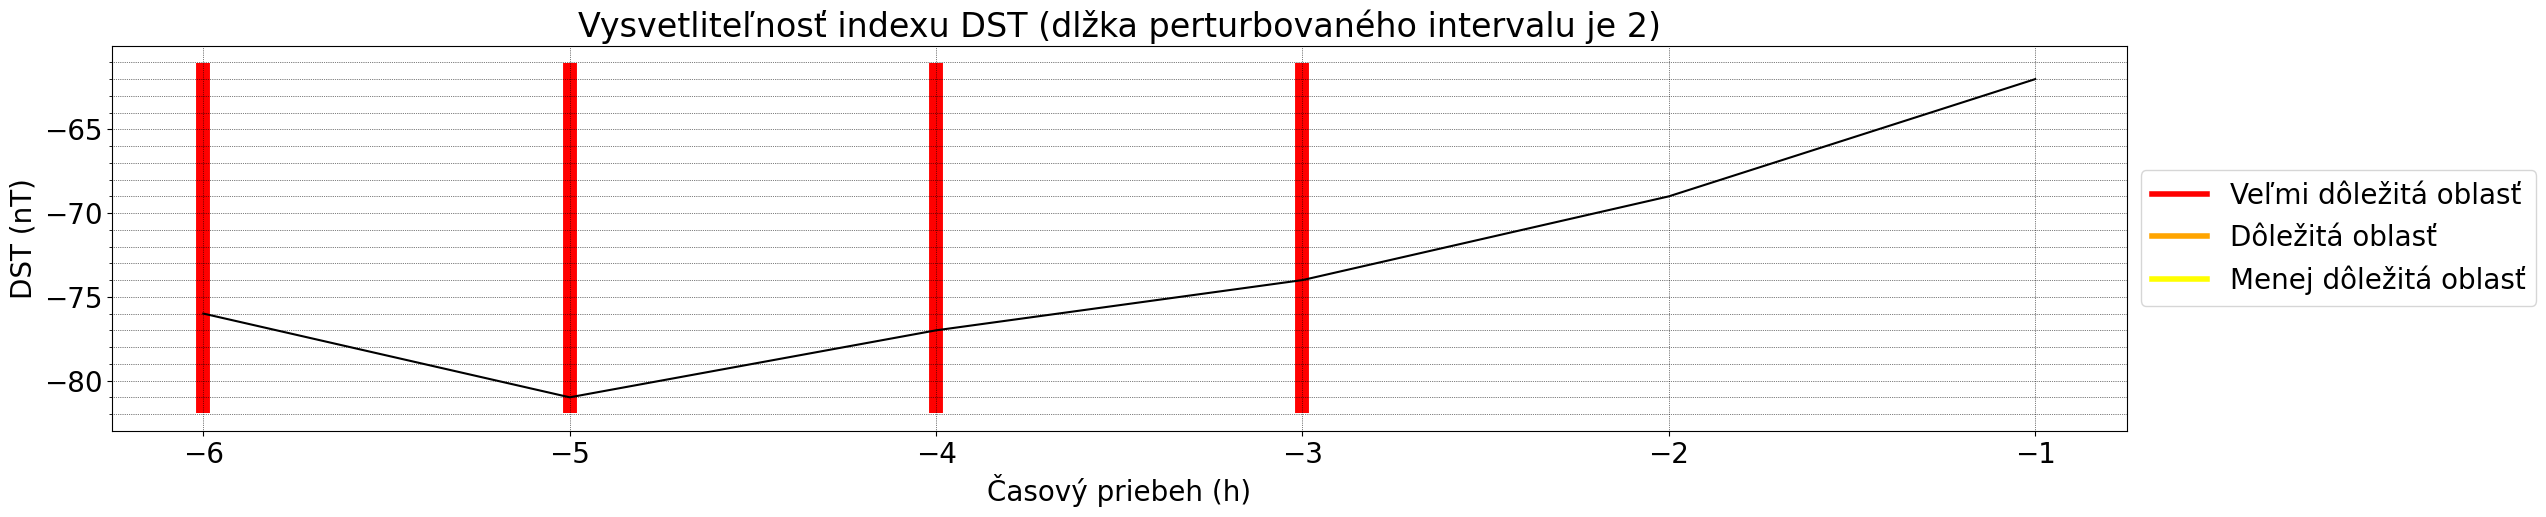

In [22]:
perturbation_method(test_generator[0][0][102], model,2, value_for_shutdown)

1/1 [==============================] - 0s 14ms/step


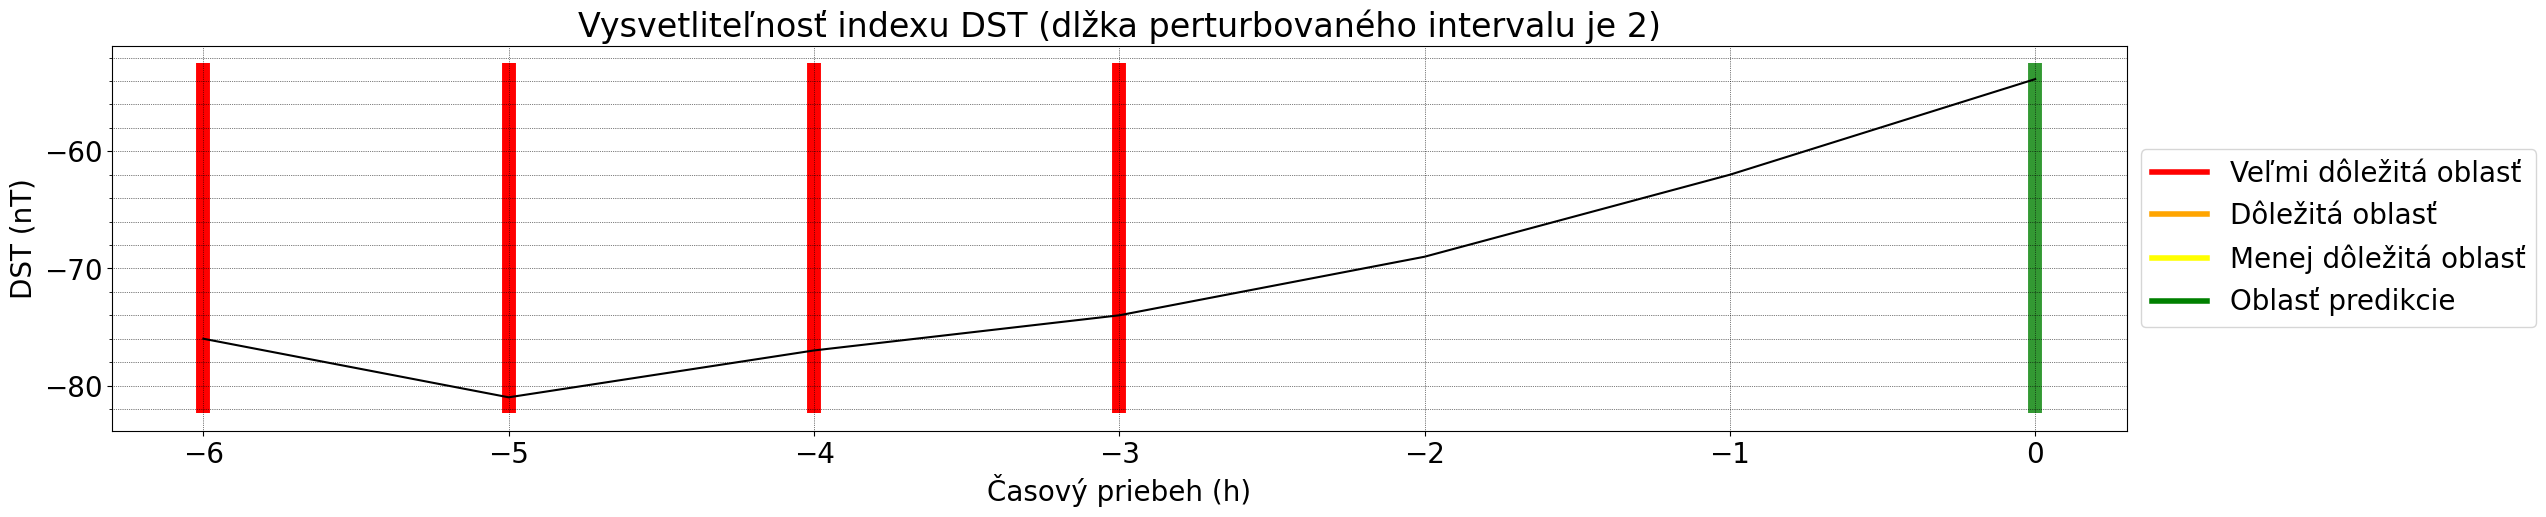

In [24]:
perturbation_method_with_predicted_value(test_generator[0][0][102], model,2, value_for_shutdown)

1/1 [==============================] - 0s 14ms/step


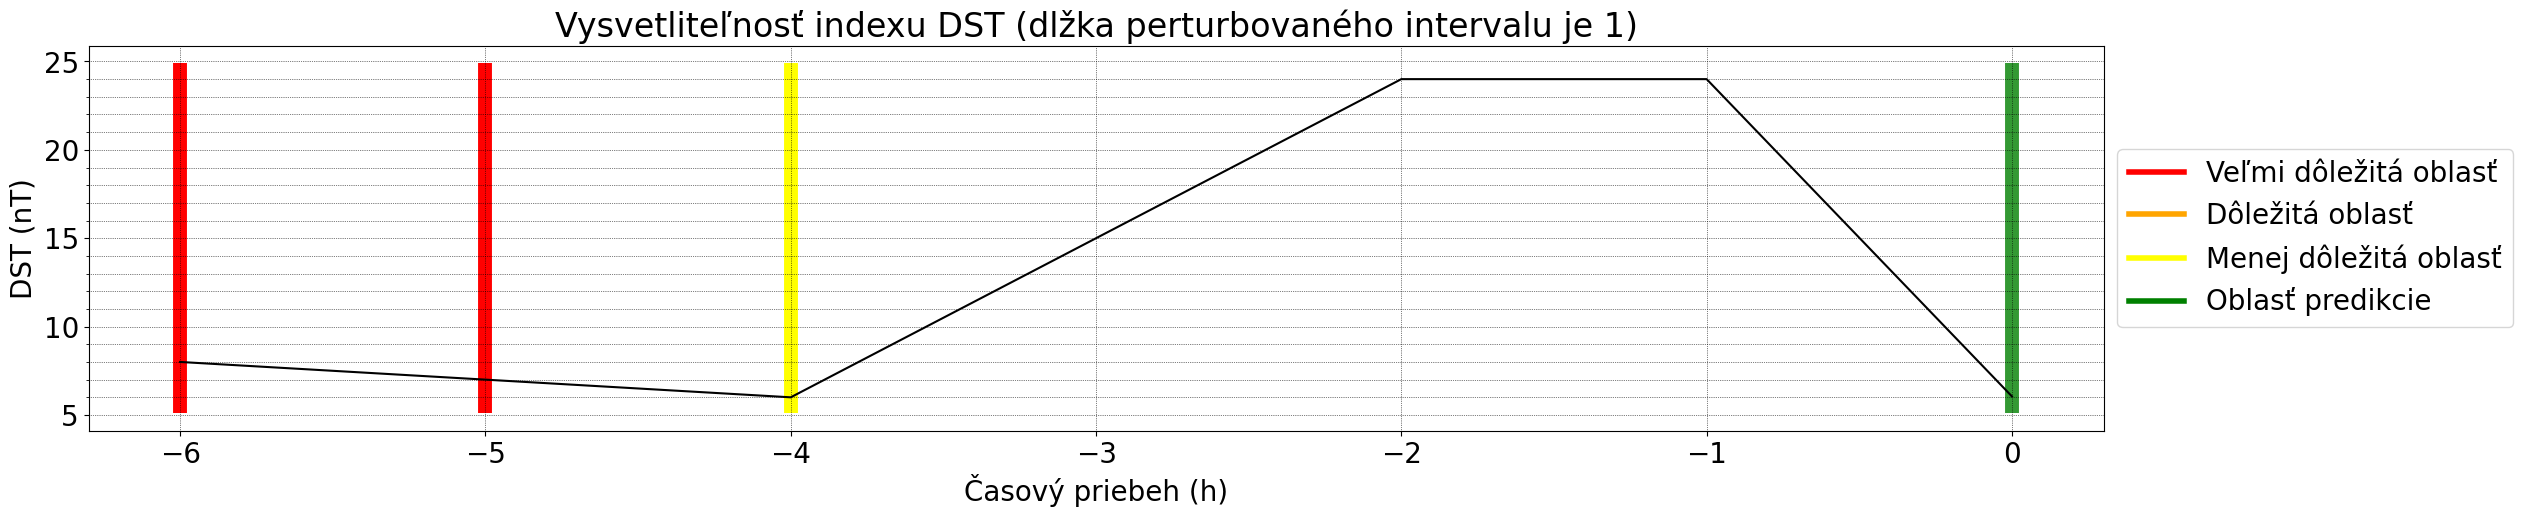

In [25]:
perturbation_method_with_predicted_value(test_generator[0][0][10], model,1, value_for_shutdown)

# Analýza 

In [26]:
sequence = []
for x, y in test_generator:
    sequence.extend(x)

In [27]:
len(sequence)

156110

In [28]:
before_2012 = df[df['time'].dt.year < 2012]
after_2017 = df[df['time'].dt.year <= 2017]

count1 = before_2012.shape[0]
count2 = after_2017.shape[0]
count1


65253

In [29]:
count2

117861

In [30]:
import os

In [31]:
# vytvorenie pričinku ak neexistuje
image_direction1 = "grafy_analyza_6_6"
os.makedirs(image_direction1, exist_ok=True)

In [ ]:
path = os.path.join(image_direction1, "grafy_analyza_perturb1_test_6_2")
os.makedirs(path, exist_ok=True)

for i in range(65254, 117861):
    if abs(sequence[i][5] - sequence[i][0]) >= 50:
        over_the_border = any(x >= -20 for x in sequence[i])
        below_the_border = any(x < -20 for x in sequence[i])

        if over_the_border and below_the_border:
            fig = perturbation_method_with_predicted_value(sequence[i], model, 1, value_for_shutdown)
            file_path = os.path.join(path, f"image_{i}.jpg") 
            fig.savefig(path, dpi=50, bbox_inches='tight') 
            #fig.savefig(file_path)
            plt.close(fig)

In [ ]:
#predikovana hodnota lok.minimom
for i in range(0, 156109):
    if sequence[i][0] - sequence[i][5] >= 50 and sequence[i][0] > sequence[i][-1]:
        over_the_border = any(x >= -20 for x in sequence[i])
        below_the_border = any(x < -20 for x in sequence[i])
        if over_the_border and below_the_border:
            if i + 1 < len(sequence):
                predicted_value = model.predict(sequence[i].reshape(1,n_input,1))
                if all(predicted_value.flatten() < sequence[i]):
                    print(sequence[i],i)  

In [34]:
# vymazanie priečinku
import shutil
shutil.rmtree(image_direction9, ignore_errors=True)

In [35]:
# vytvorenie pričinku ak neexistuje
image_direction9 = "analyza_perturb_test_6_6_lok_minimum_2004_2022"
os.makedirs(image_direction9, exist_ok=True)

In [ ]:
#predikovana hodnota lok.minimom 2004-2022 (ukladanie samostatne)

path = os.path.join(image_direction9, "grafy_perturb3")
os.makedirs(path, exist_ok=True)

for i in range(0, 156109):
    if sequence[i][0] - sequence[i][5] >= 50 and sequence[i][0] > sequence[i][-1]:
        over_the_border = any(x >= -20 for x in sequence[i])
        below_the_border = any(x < -20 for x in sequence[i])
        if over_the_border and below_the_border:
            if i + 1 < len(sequence):
                predicted_value = model.predict(sequence[i].reshape(1,n_input,1))
                if all(predicted_value.flatten() < sequence[i]):
                    fig = perturbation_method_with_predicted_value(sequence[i], model, 3, value_for_shutdown)
                    file_path = os.path.join(path, f"image_{i}.jpg") 
                    fig.savefig(file_path, dpi=50, bbox_inches='tight') 
                    plt.close(fig)

In [39]:
# vytvorenie pričinku ak neexistuje
image_direction10 = "analyza_perturb_test_6_6_lok_minimum_2004_2022_priemerna_lok_hodnota"
os.makedirs(image_direction10, exist_ok=True)

In [ ]:
#predikovana hodnota lok.minimom 2004-2022 s preimernou lokalnou hodnotou vypinania (ukladanie samostatne)

path = os.path.join(image_direction10, "grafy_perturb3")
os.makedirs(path, exist_ok=True)

for i in range(0, 156109):
    if sequence[i][0] - sequence[i][5] >= 50 and sequence[i][0] > sequence[i][-1]:
        over_the_border = any(x >= -20 for x in sequence[i])
        below_the_border = any(x < -20 for x in sequence[i])
        if over_the_border and below_the_border:
            if i + 1 < len(sequence):
                predicted_value = model.predict(sequence[i].reshape(1,n_input,1))
                if all(predicted_value.flatten() < sequence[i]):
                    fig = perturbation_method_with_predicted_value(sequence[i], model, 3, np.mean(sequence[i]))
                    file_path = os.path.join(path, f"image_{i}.jpg") 
                    fig.savefig(file_path, dpi=50, bbox_inches='tight') 
                    plt.close(fig)